# Chapter 8: Time-Varying Volatility
&copy; 2019 Kenneth Winston

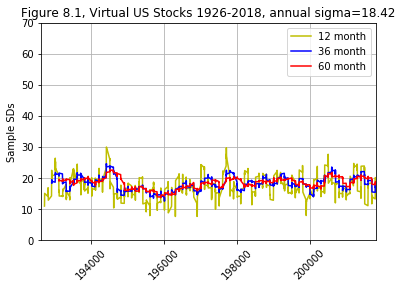

In [1]:
%matplotlib inline
import qrbook_funcs as qf
import random
import numpy as np
#Generate virtual reality for graph of standard deviations

#First get actual reality
#Cut off at last yearend
lastday=qf.LastYearEnd()
ld_yyyymm=int(lastday[:4]+lastday[5:7])
Date,market_minus_rf,SMB,HML,RF=qf.getFamaFrench3(enddate=ld_yyyymm)

ActualReality=qf.LogReturnConvert(market_minus_rf,RF)

#Compute overall monthly standard deviation
targetsd=np.std(ActualReality)

#Generate virtual reality with random normal draws with targetsd
VirtualReality=[]
random.seed(3.14159265)
for x in range(len(ActualReality)):
    VirtualReality.append(random.gauss(0,targetsd))

#Generate sample standard deviations for 3 lookback periodicities
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(VirtualReality,lookbacks)

#Draw the graph with 3 lines for the 3 periodicities
colors=['y-','b-','r-']
tstr='Figure 8.1, Virtual US Stocks '+str(Date[0])[:4]
tstr+='-'+str(Date[len(Date)-1])[:4]
tstr+=', annual sigma=%.2f' % float(targetsd*np.sqrt(12))
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

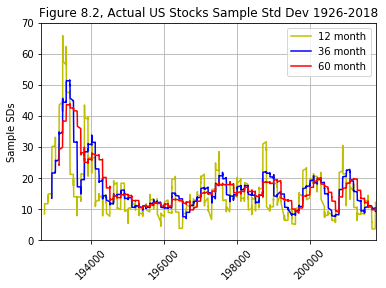

In [2]:
#Generate sample standard deviations
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(ActualReality,lookbacks)

#Graph
colors=['y-','b-','r-']
tstr='Figure 8.2, Actual US Stocks Sample Std Dev '+str(Date[0])[:4]
tstr+='-'+str(Date[len(Date)-1])[:4]
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

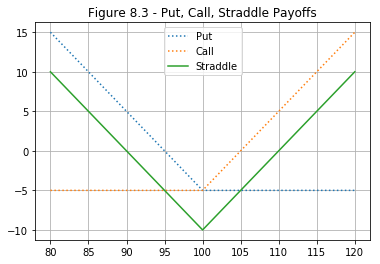

In [3]:
import matplotlib.pyplot as plt
#Draw graph showing payoff pattern of put,
#call and straddle

underprices=np.arange(80,121,1)

strike=100
cost=5
putprices=np.maximum(strike-underprices,0)-cost
callprices=np.maximum(underprices-strike,0)-cost
straddleprices=putprices+callprices
        
plt.plot(underprices,putprices,label='Put',linestyle=':')
plt.plot(underprices,callprices,label='Call',linestyle=':')
plt.plot(underprices,straddleprices,label='Straddle')
plt.title('Figure 8.3 - Put, Call, Straddle Payoffs') 
plt.legend()
plt.grid()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

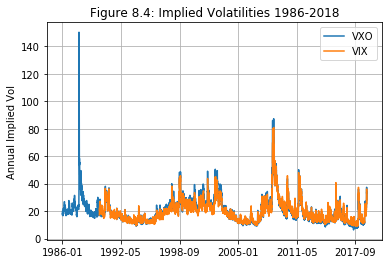

In [4]:
import pandas as pd
#Get VXO and  VIX from Fred and
#graph them.

lastday=qf.LastYearEnd()
seriesnames=['VXOCLS','VIXCLS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            enddate=lastday)

#Get rid of double nan's
vols=[]
vdates=[]
for i in range(len(ratematrix)):
    if pd.notna(ratematrix[i][0]) or pd.notna(ratematrix[i][1]):
        vols.append(ratematrix[i])
        vdates.append(cdates[i])

#vols now has VXO and VIX data where at least
#one of them is present.
x=range(len(vdates))
vxo=[row[0] for row in vols]
vix=[row[1] for row in vols]
plt.plot(x,vxo,label='VXO')
plt.plot(x,vix,label='VIX')
plt.title('Figure 8.4: Implied Volatilities '+vdates[0][:4]+'-'+vdates[len(vdates)-1][:4])

xskip=np.arange(0,len(vdates),1600)
tikskip=[vdates[x][:7] for x in xskip]
plt.xticks(xskip,tikskip)
plt.ylabel('Annual Implied Vol')
plt.legend()
plt.grid()
plt.show

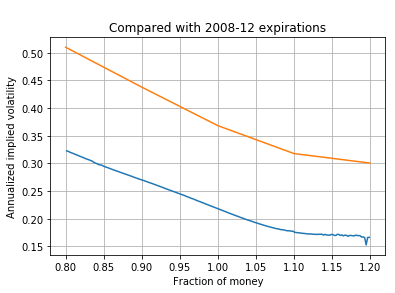

In [5]:
#Draw implied vols on two dates by moneyness
#Use downloaded file 2018-12-31 from CBOE with all option prices on that day
#Takes a LONG time to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Get all options on CBOE as of December 31, 2018
#VERY LARGE dataset, takes a long time to read
df_opts=pd.read_excel(r"UnderlyingOptionsEODCalcs_2018-12-31.xlsx")

#Subset the S&P 500 options with underlying SPX (eliminate SPXW, weekly expirations)
df_spx = df_opts[(df_opts.underlying_symbol == "^SPX") & (df_opts.root == "SPX")]

#Get S&P 500 price and quote date
spx_price = df_spx.active_underlying_price_1545.unique()[0]
quote_date = df_spx.quote_date.unique()[0]
stqd = str(quote_date)[:10]    #Display version YYYY-MM-DD

#Look between 80% of the money and 120% of the money
df_spx=df_spx[(df_spx.strike > .8*spx_price) & (df_spx.strike < 1.2*spx_price)]

#Eliminate expirations less than a week
df_spx=df_spx[df_spx.expiration>quote_date+np.timedelta64(6,'D')]

#Show strike skew of March options
df_60to90=df_spx[(df_spx.expiration>quote_date+np.timedelta64(60,'D')) & \
                 (df_spx.expiration<quote_date+np.timedelta64(90,'D'))]

strikes=[]
implieds=[]
#Find closest to the money
min_to_money = min(abs(df_spx.strike.unique()-spx_price))
for strike in df_60to90.strike.unique():
    #Average the put and call implieds at this strike
    strikes.append(strike/spx_price)
    implieds.append(np.average(df_60to90[df_60to90.strike==strike].implied_volatility_1545))
    if abs(strike-spx_price)==min_to_money:   #record ATM 60-90 implied for later use
        spx_ATM_60to90_implied = implieds[-1]

str_exp=df_60to90.expiration.iloc[0].strftime('%Y-%m-%d')
plt.plot(strikes,implieds,label=stqd)

#Add December 2008 graph
moneyness=[.8,.9,1.,1.1,1.2] 
imp2008=[0.510000164, 0.437931821, \
         0.368329438,0.31789782,0.30067243]
plt.plot(moneyness,imp2008,label='2008-12-31')

plt.xlabel("Fraction of money")
plt.ylabel("Annualized implied volatility")
plt.legend()
plt.grid()
str_title="Figure 8.5: Moneyness skew SPX options:\n Expiring "+str_exp+", Quoted "+stqd
str_title+="\nCompared with 2008-12-31 quotes"
plt.title(str_title)
plt.show()

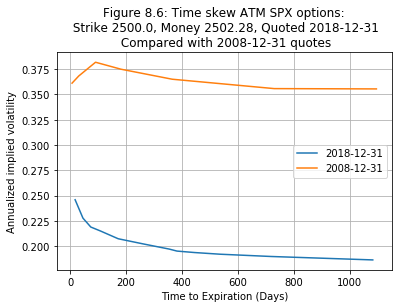

In [18]:
#Get time skew of ATM options
df_ATM=df_spx[abs(df_spx.strike-spx_price)==min_to_money]

times=[]
implieds=[]
for time in df_ATM.expiration.unique():
    #Average the put and call at this expiration date
    times.append(int((time-quote_date)/np.timedelta64(1,"D")))
    implieds.append(np.average(df_ATM[df_ATM.expiration==time].implied_volatility_1545))
    
#plt.plot(range(len(times)),implieds,label=stqd)
plt.plot(times,implieds,label=stqd)

#Add 2008-12-31 data
expiry=[7,31,91,182,365,730,1095] 
imp2008=[.3612,.3683,.3819,.3750, \
         .3651,.3558,.3555]
plt.plot(expiry,imp2008,label='2008-12-31')

plt.xlabel("Time to Expiration (Days)")
plt.ylabel("Annualized implied volatility")
plt.grid()
plt.legend()
str_strike=str(df_ATM.strike.iloc[0])
str_title="Figure 8.6: Time skew ATM SPX options:\n Strike "+str_strike
str_title+=", Money "+str(spx_price)+", Quoted "+stqd
str_title+="\n Compared with 2008-12-31 quotes"
plt.title(str_title)
plt.show();

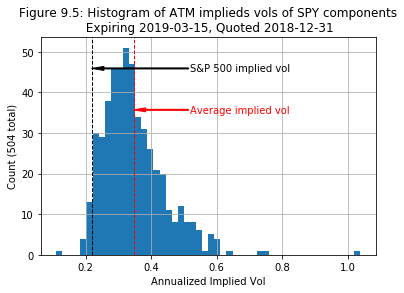

SPX implied: 0.2188
Number greater: 487
Average implied: 0.3464162119708995


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [40]:
#Prepare graph 9.5 for the next chapter to avoid reloading option data
#Graph compares ATM volatilities of components of S&P 500 with the S&P 500's vol

#Find the tickers of SPY components
df_spy=pd.read_excel(r"SPY 20190302.xlsm")
orig_spy_tickers=[]
weights=[]
for i in range(len(df_spy)):
    if type(df_spy["Ticker"].iloc(0)[i]) == type(df_spy["Ticker"].iloc(0)[0]):
        orig_spy_tickers.append(df_spy["Ticker"].iloc(0)[i].upper())
        weights.append(df_spy["Percent"].iloc(0)[i])
        
#force weights to add to 1
weights/=sum(weights)

#Get ATM implied vols for 3 months out; some have only 2 and 4 month options,
#in which case take average of 2 and 4 month ATM vols
spy_tickers=[]
implieds=[]
vis=[]   #vi's as in (9.16)
for i in range(len(orig_spy_tickers)):
    df_this_tick=df_opts[df_opts.underlying_symbol == orig_spy_tickers[i]]
    if len(df_this_tick)>0:
        df_target = df_this_tick[ \
             (df_this_tick.expiration>quote_date+np.timedelta64(60,'D')) & \
             (df_this_tick.expiration<quote_date+np.timedelta64(90,'D'))]
        if len(df_target)==0:   #See if there are expirations before and after 3 months
            df_target = df_this_tick[ \
             (df_this_tick.expiration>quote_date+np.timedelta64(30,'D')) & \
             (df_this_tick.expiration<quote_date+np.timedelta64(120,'D'))]
        if len(df_target)>0:
            spy_tickers.append(orig_spy_tickers[i])   #This one has options
            this_price = df_target.active_underlying_price_1545.unique()[0]
            quote_date = df_target.quote_date.unique()[0]
            #Find closest to the money
            min_to_money = min(abs(df_target.strike.unique()-this_price))
            df_ATM=df_target[abs(df_target.strike-this_price)==min_to_money]
            implieds.append(np.average(df_ATM.implied_volatility_1545))
            vis.append(implieds[-1]*weights[i])

#Make histogram of implieds

n, bins, patches = plt.hist(implieds,bins=50)
plt.axvline(spx_ATM_60to90_implied, color='k', linestyle='dashed', linewidth=1)
plt.annotate('S&P 500 implied vol', xy=(spx_ATM_60to90_implied, .9*max(n)), 
            xytext=(np.average(implieds)*1.5, .9*max(n)), va='center', 
            color='k', arrowprops=dict(color='k',width=1,headwidth=4))
plt.annotate('Average implied vol', xy=(np.average(implieds), .7*max(n)), 
            xytext=(np.average(implieds)*1.5, .7*max(n)), va='center',
            color='r', arrowprops=dict(color='r',width=1,headwidth=4))

plt.axvline(np.average(implieds), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Annualized Implied Vol")
plt.ylabel("Count ("+str(len(implieds))+" total)")
plt.title("Figure 9.5: Histogram of ATM implieds vols of SPY components\n Expiring " \
          +str_exp+", Quoted "+stqd)
plt.grid()
plt.show()

#Show number greater than SPX implied
n_greater = sum(iv > spx_ATM_60to90_implied for iv in implieds)
print("SPX implied:",spx_ATM_60to90_implied)
print("Number greater:",n_greater)
print("Average implied:",np.average(implieds))

#Do calculation for formula 9.16
var_port=spx_ATM_60to90_implied**2
sum_vi2=sum([vi**2 for vi in vis])
sum_vi_2=sum(vis)**2
implied_corr=(var_port-sum_vi2)/(sum_vi_2-sum_vi2)
print("Implied correlation per formula (9.16):",implied_corr)

In [ ]:
#Read time series of implied vol skews
#from csv file and graph them (time and
#moneyness skews)

file='IV skews.csv'
df=pd.read_csv(file)

#Change skew time series from strings to fractions
dates=df['Date']
timeskew=df['Time'].str.rstrip('%').astype('float')/100.0
moneyskew=df['Money'].str.rstrip('%').astype('float')/100.0

#Create a figure whose aspect ratio we can change
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(len(timeskew)),timeskew,label='Time')
ax.plot(range(len(moneyskew)),moneyskew,label='Moneyness')

ax.legend(loc='lower center',fontsize=6)
ax.grid()
plt.title('Figure 8.7: Time and Moneyness IV skews')
plt.xticks(range(0,len(timeskew)+500,500), \
          dates[dates.index % 500 == 0], \
          fontsize=6)
#Figure out size and spacing of y ticks
small=min(min(timeskew),min(moneyskew))
big=max(max(timeskew),max(moneyskew))
plt.yticks(np.arange(small,big+(big-small)/4,(big-small)/4), \
           fontsize=6)

ratio = 0.25   #x axis 4 times y axis
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
plt.show()

In [ ]:
#Draw two smiles illustrating problem
#with LVM vs Market

strikes=np.arange(1,20)
original=[(s-10)**2/10+8 for s in strikes]
mktshift=[(s-.5-10)**2/10+8 for s in strikes]
modelshift=[(s+.5-10)**2/10+8 for s in strikes]

plt.plot(strikes,original,label='Original')
plt.plot(strikes,mktshift,label='Market Shift')
plt.plot(strikes,modelshift,label='Model Shift')

plt.ylabel('Implied Vol '+r'$σ_{x0}(x,t)$')
plt.xlabel('Strike price x (moneyness)')
plt.grid()
plt.legend()
plt.title('Figure 8.8: LVM Does Not Shift the Way the Market Shifts')
plt.show()

In [ ]:
#fit GARCH(1,1) model
initparams=[.12,.85,.6]
a,b,c=qf.Garch11Fit(initparams,ActualReality)

#Display results
print("a=%.3f" % a)
print("b=%.3f" % b)
print("c=%.3f" % c)

#Draw graph
t=len(ActualReality)
minimal=10**(-20)
stdgarch=np.zeros(t)
stdgarch[0]=np.std(ActualReality)
overallmean=np.mean(ActualReality)
degarched=np.zeros(t)   #series to hold de-garched series y[t]/sigma[t]
degarched[0]=(ActualReality[0]-overallmean)/stdgarch[0]
#Compute GARCH(1,1) stddev's from data given parameters
for i in range(1,t):
    #Note offset - i-1 observation of data
    #is used for i estimate of std deviation
    previous=stdgarch[i-1]**2
    var=c+b*previous+\
        a*(ActualReality[i-1]-overallmean)**2
    stdgarch[i]=np.sqrt(var)
    degarched[i]=(ActualReality[i]-overallmean)/stdgarch[i]

#Annualize
stdgarch*=np.sqrt(12)

#Just show years
Year=[d/100 for d in Date]
    
plt.plot(Year,stdgarch)
plt.grid()
plt.title('Figure 8.9: GARCH(1,1) fit to US stock market data')
plt.ylabel('GARCH Sample SDs')
plt.axis([min(Year),max(Year),0,70])
plt.show();

In [ ]:
print('Monthly equilibrium variance c/(1-a-b):',c/(1-a-b))
print('Annual equivalent:',np.sqrt(c*12/(1-a-b)))

In [ ]:
#Compute before and after excess kurtosis
from scipy import stats
kurt_orig=stats.kurtosis(ActualReality,fisher=True)
kurt_degarch=stats.kurtosis(degarched,fisher=True)
print("Excess kurtois before and after deGarching:",kurt_orig,kurt_degarch)

In [ ]:
#Draw graph of pseudo-delta functions
xs=np.arange(-5,5.1,.1)
ks=[1,2,4]
for k in ks:
    ys=[1/(1+np.exp(k*x)) for x in xs]
    plt.plot(xs,ys,label='k='+str(k))

plt.legend()
plt.title('Figure 8.10: Pseudo-delta functions')
plt.grid()
plt.show()